In [8]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sys
sys.path.append('../')
import experiments

range_len = 7
curves = 6
curve_labels = ['Unregularized', 'All Regularizers', 'Data Augment', 'Dropout', 'Weight Decay', 'Random Labels']
curve_colors = ['blue', 'green', 'darkviolet', 'maroon', 'orange', 'red']
curve_styles = ['-', '-', '--', '--', '--', '-']
sizes = 5
size_factors = [0.25, 0.5, 1, 2, 4]
size_idx_map = {0.25: 0, 0.5: 1, 1: 2, 2: 3, 4: 4}
size_labels = ['1/4x', '1/2x', '1x', '2x', '4x']
knockout_range = np.linspace(0.0, 1.0, num=range_len)
crosses = 3

results = np.zeros((curves, sizes, 3))
results_test = np.zeros((curves, sizes, 3))
# all are indexed [size_factor][nn_type][avg/lowererr/uppererr]
# we have to make sure to not be sketchy and state that these are averages within a net instead of between nets

for ID in range(62, 92):

    print('Processing ID:', ID)
    opt = experiments.opt[ID]

    curve_idx = 0  # unregularized
    if opt.dataset.random_labels:
        curve_idx = 5  # random labels
    elif opt.hyper.augmentation and opt.hyper.drop_train < 1:
        curve_idx = 1  # all regularizers
    elif opt.hyper.augmentation:
        curve_idx = 2
    elif opt.hyper.drop_train < 1:
        curve_idx = 3
    elif opt.hyper.weight_decay:
        curve_idx = 4
    size_idx = size_idx_map[opt.dnn.neuron_multiplier[0]]

    csv_file = experiments.opt[ID].csv_dir + experiments.opt[ID].name + '_robustness.csv'
    df = pd.read_csv(csv_file)

    ablation_results = np.zeros((crosses, range_len))
    ablation_results_test = np.zeros((crosses, range_len))
    targeted_ablation_results = np.zeros((crosses, range_len))
    targeted_ablation_results_test = np.zeros((crosses, range_len))    
    for cross in range(crosses):
        for amount in range(range_len):
            ablation_results[cross, amount] = df[df['cross_validation'] == cross][df['evaluation_set'] == 'train'] \
                [df['perturbation_layer'] == 'all'][df['perturbation_name'] == 'Activation Knockout'] \
                [df['perturbation_amount'] == knockout_range[amount]]['performance'].iloc[0]
            ablation_results_test[cross, amount] = df[df['cross_validation'] == cross] \
                [df['evaluation_set'] == 'test'][df['perturbation_layer'] == 'all'] \
                [df['perturbation_name'] == 'Activation Knockout'][df['perturbation_amount'] == knockout_range[amount]] \
                ['performance'].iloc[0]
            targeted_ablation_results[cross, amount] = df[df['cross_validation'] == cross][df['evaluation_set'] == 'train'] \
                [df['perturbation_layer'] == 'all'][df['perturbation_name'] == 'Activation Knockout Selected'] \
                [df['perturbation_amount'] == knockout_range[amount]]['performance'].iloc[0]
            targeted_ablation_results_test[cross, amount] = df[df['cross_validation'] == cross] \
                [df['evaluation_set'] == 'test'][df['perturbation_layer'] == 'all'] \
                [df['perturbation_name'] == 'Activation Knockout Selected'][df['perturbation_amount'] == knockout_range[amount]] \
                ['performance'].iloc[0]
                
    ablation_results = np.mean(ablation_results, axis=1)
    ablation_results_test = np.mean(ablation_results_test, axis=1)
    targeted_ablation_results = np.mean(targeted_ablation_results, axis=1)
    targeted_ablation_results_test = np.mean(targeted_ablation_results_test, axis=1)
    
    drop_results = ablation_results - targeted_ablation_results
    drop_results_test = ablation_results_test - targeted_ablation_results_test

    results[curve_idx, size_idx, 0] = np.mean(drop_results)
    results[curve_idx, size_idx, 1] = results[curve_idx, size_idx, 0] - np.min(drop_results)
    results[curve_idx, size_idx, 2] = np.max(drop_results) - results[curve_idx, size_idx, 0]
    results_test[curve_idx, size_idx, 0] = np.mean(drop_results_test)
    results_test[curve_idx, size_idx, 1] = results_test[curve_idx, size_idx, 0] - np.min(drop_results_test)
    results_test[curve_idx, size_idx, 2] = np.max(drop_results_test) - results_test[curve_idx, size_idx, 0]

Processing ID: 62
Processing ID: 63
Processing ID: 64
Processing ID: 65
Processing ID: 66
Processing ID: 67
Processing ID: 68
Processing ID: 69
Processing ID: 70
Processing ID: 71
Processing ID: 72
Processing ID: 73
Processing ID: 74
Processing ID: 75
Processing ID: 76
Processing ID: 77
Processing ID: 78
Processing ID: 79
Processing ID: 80
Processing ID: 81
Processing ID: 82
Processing ID: 83
Processing ID: 84
Processing ID: 85
Processing ID: 86
Processing ID: 87
Processing ID: 88
Processing ID: 89
Processing ID: 90
Processing ID: 91


/cm/shared/openmind/anaconda/2.5.0/lib/python3.5/site-packages/pandas/core/frame.py:1997: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  "DataFrame index.", UserWarning)


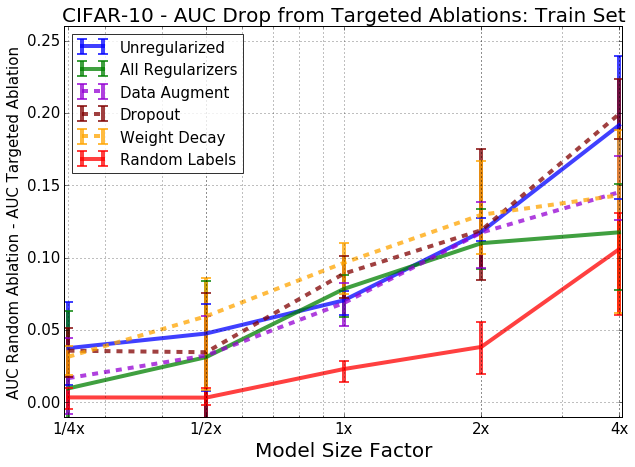

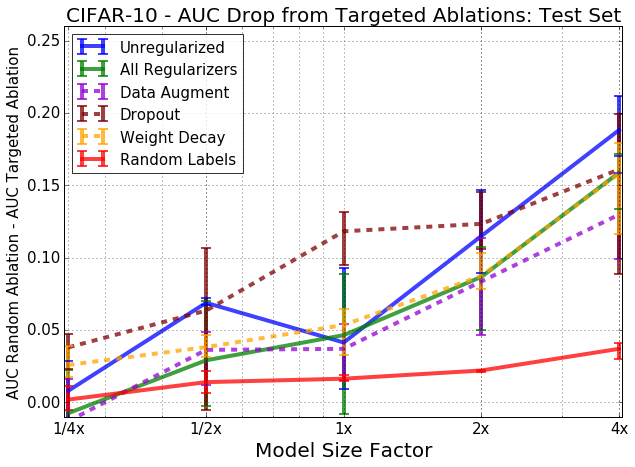

In [9]:
# first plot train curves

% matplotlib inline
plt.figure(figsize=(10, 7))
plt.title('CIFAR-10 - AUC Drop from Targeted Ablations: Train Set', fontsize=20)
plt.xlabel('Model Size Factor', fontsize=20)
plt.ylabel('AUC Random Ablation - AUC Targeted Ablation', fontsize=15)
plt.xlim((0.245, 4.07))
plt.ylim((-0.01, 0.26))
plt.grid(True, which='both', c='black')
plt.xscale('log')
plt.xticks(size_factors, size_labels, fontsize=15)
plt.yticks(fontsize=15)

for curve_idx in range(curves):
    plt.errorbar(size_factors, results[curve_idx, :, 0], yerr=results[curve_idx, :, 1:].T,
                 color=curve_colors[curve_idx], linestyle=curve_styles[curve_idx], 
                 linewidth=4, capsize=5, capthick=2, alpha=0.75)
plt.legend(curve_labels, loc='upper left', framealpha=0.8, fontsize=15)

plt.show()

# second plot test curves

plt.figure(figsize=(10, 7))
plt.title('CIFAR-10 - AUC Drop from Targeted Ablations: Test Set', fontsize=20)
plt.xlabel('Model Size Factor', fontsize=20)
plt.ylabel('AUC Random Ablation - AUC Targeted Ablation', fontsize=15)
plt.xlim((0.245, 4.07))
plt.ylim((-0.01, 0.26))
plt.grid(True, which='both', c='black')
plt.xscale('log')
plt.xticks(size_factors, size_labels, fontsize=15)
plt.yticks(fontsize=15)

for curve_idx in range(curves):
    plt.errorbar(size_factors, results_test[curve_idx, :, 0], yerr=results_test[curve_idx, :, 1:].T,
                 color=curve_colors[curve_idx], linestyle=curve_styles[curve_idx], 
                 linewidth=4, capsize=5, capthick=2, alpha=0.75)
plt.legend(curve_labels, loc='upper left', framealpha=0.8, fontsize=15)

plt.show()